# Toy Example

This notebook implements the toy example from the paper: fitting the seam line curve of the tennis ball.

We generate a point cloud around this curve and show how to approximate this line by intersection of two quadric surfaces. Also we add an outlier point and compare the robustness of the proposed technique from the paper and quadratic kernel PCA.

We start by importing the necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import fsolve
from scipy import linalg
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm


import sys
sys.path.append("..")
from quadrics.quadrics_wrapper import Quadrics

%matplotlib inline

## Points Cloud Generation

Seam line can be described by the following parametrisation
$$
\begin{cases}
x(t) = a \cos(t) + b \cos(3t) \\
y(t) = a \sin(t) - b \sin(3t) \\
z(t) = 2 \sqrt{ab} \sin(2t)
\end{cases}
$$
where $t \in [0, 2\pi]$.

We generate points on this curve by means of the parameterization and subsequently add uniform noise to them.

An outlier point is sampled from normal distribution in the ambient $3$-dimensional Euclidean space.

(-2.5, 2.5)

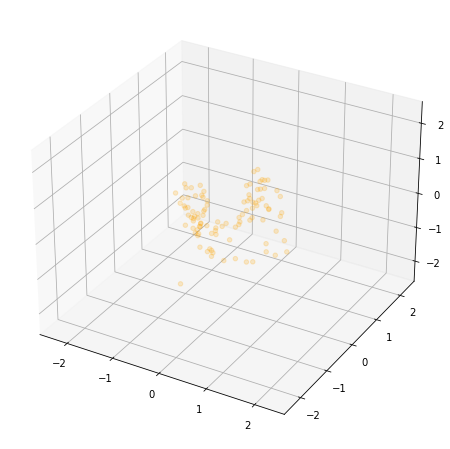

In [2]:
np.random.seed(69)
size, outliers_size = 100, 1
r, p = 1, 0.8
a, b = p*r, (1 - p)*r
t = np.random.uniform(0, 2*np.pi, size)

x_line = a*np.cos(t) + b*np.cos(3*t)
y_line = a*np.sin(t) - b*np.sin(3*t)
z_line = 2*np.sqrt(a*b)*np.sin(2*t)

true_points = np.stack([x_line, y_line, z_line]).T

# noise
noise = np.random.normal(scale=0.12*r, size=(size, 3))
noised_points = true_points + noise

outliers = np.random.normal(scale=1, size=(3, outliers_size))
outliers = 2 * outliers/np.linalg.norm(outliers, axis=0) #+ outliers_n
points = np.vstack([noised_points, outliers.T])
points = np.random.permutation(points)

t_curve = np.linspace(-np.pi, np.pi, 50)
x_curve = a*np.cos(t_curve) + b*np.cos(3*t_curve)
y_curve = a*np.sin(t_curve) - b*np.sin(3*t_curve)
z_curve = 2*np.sqrt(a*b)*np.sin(2*t_curve)

x, y, z = points.T

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, alpha=0.2, c='orange')

scale = 2.5
xmin, xmax, ymin, ymax, zmin, zmax = (-scale, scale)*3

ax.set_zlim3d(zmin,zmax)
ax.set_xlim3d(xmin,xmax)
ax.set_ylim3d(ymin,ymax)

## Kernel PCA Training

In [3]:
def feature_map(X):
    q = np.einsum('ki,kj->kij',X,X)[(slice(None),) + np.triu_indices(X.shape[-1])]
    return np.hstack((q,X,np.ones((X.shape[0],1))))
def feature_map_q(X):
    return np.einsum('ki,kj->kij',X,X)[(slice(None),) + np.triu_indices(X.shape[-1])]
def projector_q(dim):
    return np.diag(np.hstack((np.ones(dim * (dim + 1) // 2), np.zeros(dim + 1))))

In [4]:
PhiX = feature_map(points)
cov = (PhiX).T.dot(PhiX)
w, v = linalg.eig(cov, b = projector_q(points.shape[1]))
coeffs = v[:,np.argsort(np.real(w))[:2]]

## Quadrics Training

We will train quadrics using our API.

In [5]:
quadrics = Quadrics(n_quadrics=2, dist='dist2_full', device='gpu')
quadrics.fit(points, 500, learning_rate=0.1, batch_size=20, vebrose=100)

Epoch 100
Orthonormal error: 0.006873855367302895
Epoch 200
Orthonormal error: 0.010149871930480003
Epoch 300
Orthonormal error: 0.006793696898967028
Epoch 400
Orthonormal error: 0.0055059706792235374
Epoch 500
Orthonormal error: 0.014516441151499748


## Calculations for lines

Import some stuff for ploting implicit lines

In [6]:
from utils.graph_utils import GridSolver, get_points_line

Let's build line blocks for quadrics

In [7]:
x = np.linspace(-2, 2, num=10)
y = np.linspace(-2, 2, num=10)
grid = np.array(np.meshgrid(x, y)).reshape((2, -1)).T
z = np.linspace(-4, 4, num=100)

q_points = []
for z_0 in tqdm(z):
    def equations(p):
        x, y = p
        p_0 = np.array([x, y, z_0])
        return quadrics.get_distances(p_0, dist='dist0')
    gs = GridSolver(equations, grid)
    sols = gs.find()
    for p in sols:
        x, y = p
        q_points.append((x, y, z_0))

quad_bloks = get_points_line(np.array(q_points))

100%|██████████| 100/100 [01:29<00:00,  1.11it/s]


And for kPCA

In [8]:
def get_coeff_matrix(coeffs, ndim):
    quadratic = coeffs[:ndim*(ndim + 1)//2]
    linear = coeffs[ndim*(ndim + 1)//2:-1]
    free = coeffs[-1]
    M = np.zeros((ndim + 1, ndim + 1))
    M[np.triu_indices(3)] = quadratic
    M[np.tril_indices(3)] = M.T[np.tril_indices(3)]
    M[ndim, :ndim] = linear
    M[:ndim, ndim] = linear
    M[ndim, ndim] = free
    return M

def quadric_value(coeffs, point):
    point1 = np.append(point,1)  
    return point1.T.dot(coeffs.dot(point1))

In [9]:
x = np.linspace(-2, 2, num=10)
y = np.linspace(-2, 2, num=10)
grid = np.array(np.meshgrid(x, y)).reshape((2, -1)).T
z = np.linspace(-2, 2, num=100)

q_points = []
for z_0 in tqdm(z):
    def equations(p):
        x, y = p
        p_0 = np.array([x, y, z_0])
        #return quadrics.get_distances(p_0, dist='dist0')
        return [quadric_value(get_coeff_matrix(coeffs[:, 0], 3),p_0),quadric_value(get_coeff_matrix(coeffs[:, 1], 3),p_0)]
    gs = GridSolver(equations, grid)
    sols = gs.find()
    for p in sols:
        x, y = p
        q_points.append((x, y, z_0))
        
kpca_bloks = get_points_line(np.array(q_points))

100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


## Final picture

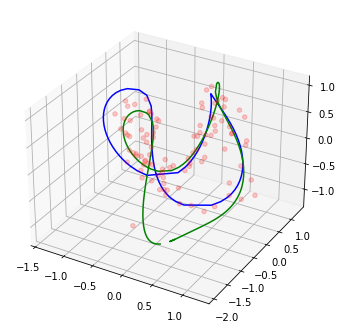

In [10]:
fig = plt.figure(figsize=(4, 4))
fig.subplots_adjust(left=-0.05, right=1.05, bottom=-0.5, top=1.5)
ax = fig.add_subplot(111, projection='3d')

x, y, z = points.T
ax.scatter(x, y, z, alpha=0.2, c='red')

# dist2 solution
for block in quad_bloks:
    ax.plot(block[:,0], block[:,1], block[:, 2], c = 'blue')
    
for block in kpca_bloks:
    ax.plot(block[:,0], block[:,1], block[:, 2], c = 'green')    